In [ ]:
# Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# TensorFlow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from pathlib import Path
import os.path
import zipfile
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/skin_disease.zip'
extract_path = '/content/drive/MyDrive/Colab Notebooks'

In [ ]:

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the contents
print("Files extracted to:", extract_path)

Files extracted to: /content/drive/MyDrive/Colab Notebooks


In [ ]:
#helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-06-01 04:11:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-01 04:11:49 (70.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
skin_disease_dataset = '/content/drive/MyDrive/Capstone/skin_disease'
walk_through_dir(skin_disease_dataset)

There are 14 directories and 0 images in '/content/drive/MyDrive/Capstone/skin_disease'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Capstone/skin_disease/acne'.
There are 0 directories and 271 images in '/content/drive/MyDrive/Capstone/skin_disease/basal_cell_carcinoma'.
There are 0 directories and 170 images in '/content/drive/MyDrive/Capstone/skin_disease/chicken_pox'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Capstone/skin_disease/eksim'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Capstone/skin_disease/melanoctyic_nevi'.
There are 0 directories and 247 images in '/content/drive/MyDrive/Capstone/skin_disease/melanoma'.
There are 1 directories and 100 images in '/content/drive/MyDrive/Capstone/skin_disease/psoriasis_pictures_lichen_planus_and_related_diseases'.
There are 0 directories and 126 images in '/content/drive/MyDrive/Capstone/skin_disease/psoriasis_pictures_lichen_planus_and_related_diseases/normal_skin'.
T

In [ ]:
img_directory = Path(skin_disease_dataset)
filepaths = list(img_directory.glob(r'**/*.JPG')) + list(img_directory.glob(r'**/*.jpg')) + list(img_directory.glob(r'**/*.png')) + list(img_directory.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Capstone/skin_disease/b...,basal_cell_carcinoma
1,/content/drive/MyDrive/Capstone/skin_disease/b...,basal_cell_carcinoma
2,/content/drive/MyDrive/Capstone/skin_disease/b...,basal_cell_carcinoma
3,/content/drive/MyDrive/Capstone/skin_disease/b...,basal_cell_carcinoma
4,/content/drive/MyDrive/Capstone/skin_disease/b...,basal_cell_carcinoma
...,...,...
2422,/content/drive/MyDrive/Capstone/skin_disease/u...,urticaria_hives
2423,/content/drive/MyDrive/Capstone/skin_disease/u...,urticaria_hives
2424,/content/drive/MyDrive/Capstone/skin_disease/u...,urticaria_hives
2425,/content/drive/MyDrive/Capstone/skin_disease/u...,urticaria_hives


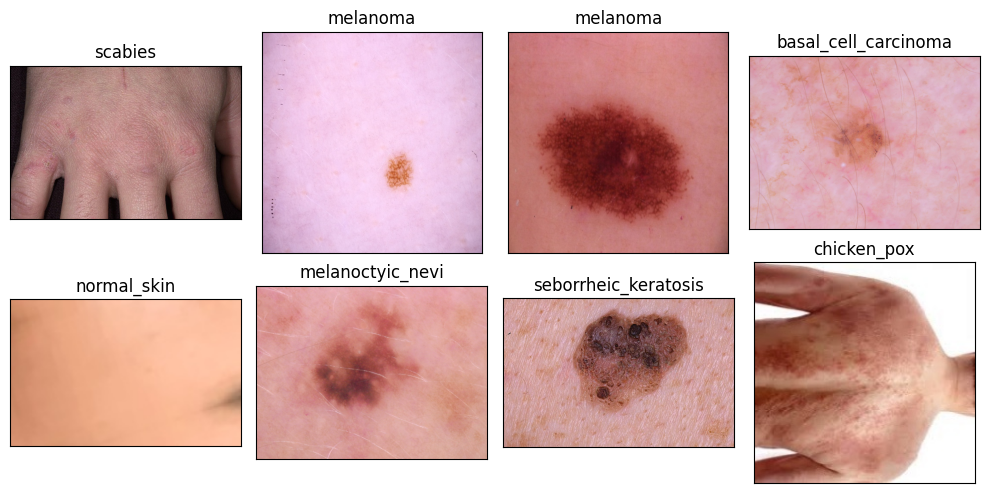

In [ ]:
# Display 8 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [ ]:
#separate to training, validation, testing
training_dataset, testing_dataset = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
training_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training')

validation_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='validation')

test_images = test_generator.flow_from_dataframe(
dataframe = testing_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False)

Found 1553 validated image filenames belonging to 14 classes.
Found 388 validated image filenames belonging to 14 classes.
Found 486 validated image filenames belonging to 14 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomZoom(0.3),
    preprocessing.RandomRotation(0.4),
    preprocessing.RandomWidth(0.3),
    preprocessing.RandomHeight(0.3)
], name="data_augmentation")

In [ ]:
input_shape = (224,224,3)
Base_Model = tf.keras.applications.MobileNetV3Large(
input_shape=input_shape,
include_top = False,
    weights = 'imagenet',
    pooling='avg'
)
Base_Model.trainable = False

In [ ]:
def build_model(base_model, num_classes):
    inputs = base_model.input
    x = data_augmentation(inputs)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

num_classes = 14

# Load the base model with pre-trained weights, exclude the top layers
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, pooling='avg')

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Build the model
model = build_model(base_model, num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
tensorboard_callback = TensorBoard(log_dir="training_logs/skin_disease_classification")
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Fit the model
history = model.fit(
    training_images,
    steps_per_epoch=len(training_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=150,
    callbacks=[
        early_stopping,
        reduce_lr,
        tensorboard_callback,
        model_checkpoint,
    ]
)

Epoch 1/150
49/49 [==============================] - ETA: 0s - loss: 9.8997 - accuracy: 0.0850

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 84s 1s/step - loss: 9.8997 - accuracy: 0.0850 - val_loss: 9.1152 - val_accuracy: 0.0928 - lr: 1.0000e-04
Epoch 2/150
49/49 [==============================] - 25s 505ms/step - loss: 9.6725 - accuracy: 0.0992 - val_loss: 9.0587 - val_accuracy: 0.1082 - lr: 1.0000e-04
Epoch 3/150
49/49 [==============================] - 24s 499ms/step - loss: 9.4572 - accuracy: 0.1204 - val_loss: 8.9558 - val_accuracy: 0.1495 - lr: 1.0000e-04
Epoch 4/150
49/49 [==============================] - 23s 477ms/step - loss: 9.2002 - accuracy: 0.1462 - val_loss: 8.7792 - val_accuracy: 0.2371 - lr: 1.0000e-04
Epoch 5/150
49/49 [==============================] - 24s 495ms/step - loss: 8.9994 - accuracy: 0.1822 - val_loss: 8.5844 - val_accuracy: 0.2861 - lr: 1.0000e-04
Epoch 6/150
49/49 [==============================] - 25s 511ms/step - loss: 8.7935 - accuracy: 0.2228 - val_loss: 8.4019 - val_accuracy: 0.3582 - lr: 1.0000e-04
Epoch 7/150
49/49 [==============================

In [ ]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

16/16 - 77s - loss: 0.5353 - accuracy: 0.9444 - 77s/epoch - 5s/step
    Test Loss: 0.53526
Test Accuracy: 94.44%


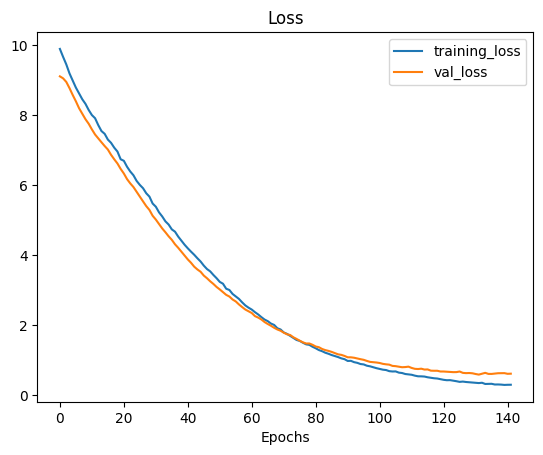

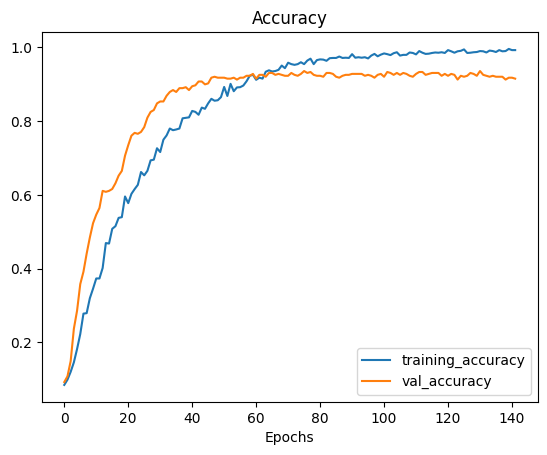

In [ ]:
plot_loss_curves(history)

In [ ]:
model.save('train_model_mobileNetV3_tes.h5')

In [ ]:
 converter = tf.lite.TFLiteConverter.from_keras_model(model)
 tflite_model = converter.convert()

 with open('model.tflite_2', 'wb') as f:
   f.write(tflite_model)

In [ ]:
history.history #Return Dictionary of history

{'loss': [9.899699211120605,
  9.672532081604004,
  9.457171440124512,
  9.200180053710938,
  8.999385833740234,
  8.793538093566895,
  8.626443862915039,
  8.46056079864502,
  8.32901668548584,
  8.154000282287598,
  8.008780479431152,
  7.918694972991943,
  7.7210307121276855,
  7.551340103149414,
  7.472249507904053,
  7.307539939880371,
  7.214271068572998,
  7.075578212738037,
  6.964871406555176,
  6.744892597198486,
  6.700422763824463,
  6.530551910400391,
  6.395308971405029,
  6.287109375,
  6.125136375427246,
  6.010970592498779,
  5.916733264923096,
  5.773090839385986,
  5.676507472991943,
  5.479046821594238,
  5.388026237487793,
  5.226647853851318,
  5.109307289123535,
  4.969296455383301,
  4.878501892089844,
  4.73967981338501,
  4.673618316650391,
  4.5333075523376465,
  4.418783187866211,
  4.300240516662598,
  4.19814920425415,
  4.103518962860107,
  4.01399564743042,
  3.9137063026428223,
  3.82106876373291,
  3.7039525508880615,
  3.605673313140869,
  3.539659500

In [ ]:
# Convert history.history to a JSON-serializable format
history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}

# Save the history to a JSON file
import json
with open('train_hist_mobileNetV3_new2.json', 'w') as f:
    json.dump(history_dict, f)

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [ ]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 91.49484634399414 %


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

16/16 [==============================] - 6s 338ms/step
The first 5 predictions: ['acne', 'melanoctyic_nevi', 'eksim', 'urticaria_hives', 'ringworm']


In [ ]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(testing_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_dataset.Filepath.iloc[random_index[i]]))
    if testing_dataset.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {testing_dataset.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_test = list(testing_dataset.Label)
print(classification_report(y_test, pred))

                                                       precision    recall  f1-score   support

                                                 acne       0.91      0.98      0.94        43
                                 basal_cell_carcinoma       0.98      0.94      0.96        47
                                          chicken_pox       1.00      1.00      1.00        23
                                                eksim       0.89      0.86      0.87        36
                                     melanoctyic_nevi       0.85      0.92      0.88        24
                                             melanoma       0.98      0.98      0.98        54
                                          normal_skin       1.00      1.00      1.00        46
psoriasis_pictures_lichen_planus_and_related_diseases       0.93      0.76      0.84        17
                                             ringworm       0.90      0.90      0.90        20
                                              sca

In [ ]:
import tensorflow as tf
import pathlib

# Specify the correct path to your model
model_path = '/content/drive/MyDrive/Capstone/train_model_mobileNetV3.h5'

# Load the Keras model
try:
    model = tf.keras.models.load_model(model_path)
except OSError as e:
    print(f"Error loading model: {e}")

# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Specify the file name and path for the TFLite model
tflite_model_file = pathlib.Path('/content/drive/MyDrive/Capstone/train_model_mobileNetV3_.tflite')

# Save the TFLite model to a file
tflite_model_file.write_bytes(tflite_model)

print(f"TFLite model saved to: {tflite_model_file}")


Error loading model: No file or directory found at /content/drive/MyDrive/Capstone/train_model_mobileNetV3.h5
TFLite model saved to: /content/drive/MyDrive/Capstone/train_model_mobileNetV3_.tflite
